In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

In [2]:
# Read the CSV file
df = pd.read_csv('data/GE.csv')

In [3]:
# Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])

In [4]:
# Variables for training
cols = list(df)[1:6]

In [5]:
# New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

In [6]:
# Normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [7]:
# Define input shape
input_shape = (None, df_for_training_scaled.shape[1])

In [8]:
# Prepare data for training
n_future = 1
n_past = 14
trainX, trainY = [], []

In [9]:
for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
    trainX.append(df_for_training_scaled[i - n_past:i])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future])

In [10]:
trainX, trainY = np.array(trainX), np.array(trainY)

In [11]:
# Define the Functional API model
input_layer = Input(shape=input_shape)
lstm1 = LSTM(64, activation='relu', return_sequences=True)(input_layer)
lstm2 = LSTM(32, activation='relu', return_sequences=False)(lstm1)
dropout = Dropout(0.2)(lstm2)
output_layer = Dense(trainY.shape[1])(dropout)

In [12]:
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 5)]         0         
                                                                 
 lstm (LSTM)                 (None, None, 64)          17920     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/5
14/14 [==============================] - 6s 77ms/step - loss: 0.8519 - val_loss: 1.8432
Epoch 2/5
14/14 [==============================] - 0s 18ms/step - loss: 0.8298 - val_loss: 1.7627
Epoch 3/5
14/14 [==============================] - 0s 18ms/step - loss: 0.8271 - val_loss: 1.6585
Epoch 4/5
14/14 [==============================] - 0s 18ms/step - loss: 0.8274 - val_loss: 1.6561
Epoch 5/5
14/14 [==============================] - 0s 18ms/step - loss: 0.8260 - val_loss: 1.6392


In [14]:
# Predict future dates
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
n_past = 16
n_days_for_prediction = 15

In [15]:
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()

In [16]:
prediction = model.predict(trainX[-n_days_for_prediction:])
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:, 0]

1/1 [==============================] - 1s 663ms/step


In [17]:
forecast_dates = [time_i.date() for time_i in predict_period_dates]
df_forecast = pd.DataFrame({'Date': forecast_dates, 'Open': y_pred_future})
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

In [18]:
# Plot the original and forecasted data
original = df[['Date', 'Open']]
original['Date'] = pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-05-01']

C:\Users\sazid\AppData\Local\Temp\ipykernel_736\1843836649.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date'] = pd.to_datetime(original['Date'])


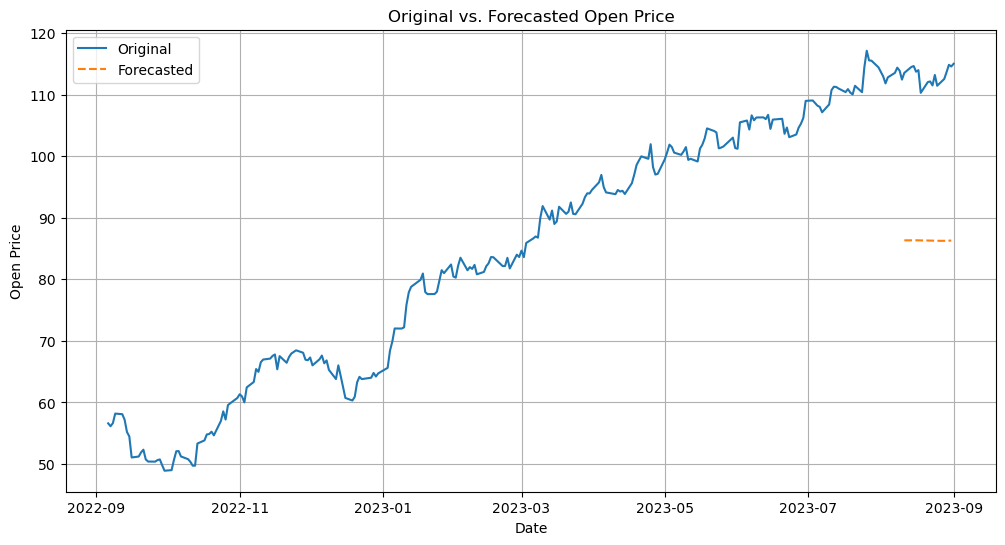

In [20]:
import matplotlib.pyplot as plt

# Plot the original and forecasted data using Matplotlib
plt.figure(figsize=(12, 6))
plt.plot(original['Date'], original['Open'], label='Original')
plt.plot(df_forecast['Date'], df_forecast['Open'], label='Forecasted', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Original vs. Forecasted Open Price')
plt.legend()
plt.grid(True)
plt.show()